In [4]:
#Data Cleaning and Organizing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#pre processing
from sklearn.preprocessing import LabelEncoder

#Modeling
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [5]:
#each data set, not included in github
buildMetData = pd.read_csv('energyCSV/building_metadata.csv')
samSub = pd.read_csv('energyCSV/sample_submission.csv')
test = pd.read_csv('energyCSV/test.csv')
train = pd.read_csv('energyCSV/train.csv')
weatherTest = pd.read_csv('energyCSV/weather_test.csv')
weatherTrain = pd.read_csv('energyCSV/weather_train.csv')

In [6]:
# Function to reduce the DF size
# Code from Kaggle user Koustav Banerjee

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

weatherTrain = reduce_mem_usage(weatherTrain)
weatherTest = reduce_mem_usage(weatherTest)
buildMetData = reduce_mem_usage(buildMetData)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [8]:
buildMetData

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.0,NaN
1445,15,1445,Education,4298,NaN,NaN
1446,15,1446,Entertainment/public assembly,11265,1997.0,NaN
1447,15,1447,Lodging/residential,29775,2001.0,NaN


In [9]:
samSub

,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
41697595,41697595,0
41697596,41697596,0
41697597,41697597,0
41697598,41697598,0


In [10]:
test

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00
...,...,...,...,...
41697595,41697595,1444,0,2018-05-09 07:00:00
41697596,41697596,1445,0,2018-05-09 07:00:00
41697597,41697597,1446,0,2018-05-09 07:00:00
41697598,41697598,1447,0,2018-05-09 07:00:00


In [11]:
train

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000000
1,1,0,2016-01-01 00:00:00,0.000000
2,2,0,2016-01-01 00:00:00,0.000000
3,3,0,2016-01-01 00:00:00,0.000000
4,4,0,2016-01-01 00:00:00,0.000000
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000
20216096,1445,0,2016-12-31 23:00:00,4.825000
20216097,1446,0,2016-12-31 23:00:00,0.000000
20216098,1447,0,2016-12-31 23:00:00,159.574997


In [12]:
weatherTrain

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.093750,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.093750,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.593750,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.000000,-1.0,1020.0,250.0,2.599609
...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,3.000000,NaN,-8.000000,NaN,NaN,180.0,5.699219
139769,15,2016-12-31 20:00:00,2.800781,2.0,-8.898438,NaN,1007.5,180.0,7.699219
139770,15,2016-12-31 21:00:00,2.800781,NaN,-7.199219,NaN,1007.5,180.0,5.101562
139771,15,2016-12-31 22:00:00,2.199219,NaN,-6.699219,NaN,1008.0,170.0,4.601562


In [13]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

weatherTrain['timestamp'] = pd.to_datetime(weatherTrain['timestamp'])
weatherTest['timestamp'] = pd.to_datetime(weatherTest['timestamp'])

buildMetData['primary_use'] = buildMetData['primary_use'].astype('category')

In [14]:
train["hour"] = train["timestamp"].dt.hour
train["day"] = train["timestamp"].dt.day
train["weekend"] = train["timestamp"].dt.weekday
train["month"] = train["timestamp"].dt.month

test["hour"] = test["timestamp"].dt.hour
test["day"] = test["timestamp"].dt.day
test["weekend"] = test["timestamp"].dt.weekday
test["month"] = test["timestamp"].dt.month

In [15]:
temp_df = train[['building_id']]
temp_df = temp_df.merge(buildMetData, on=['building_id'], how='left')
del temp_df['building_id']
train = pd.concat([train, temp_df], axis=1)

temp_df = test[['building_id']]
temp_df = temp_df.merge(buildMetData, on=['building_id'], how='left')
del temp_df['building_id']
test = pd.concat([test, temp_df], axis=1)

del temp_df, buildMetData

In [16]:
temp_df = train[['site_id','timestamp']]
temp_df = temp_df.merge(weatherTrain, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
train = pd.concat([train, temp_df], axis=1)

temp_df = test[['site_id','timestamp']]
temp_df = temp_df.merge(weatherTest, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
test = pd.concat([test, temp_df], axis=1)

del temp_df, weatherTrain, weatherTest

In [17]:
le = LabelEncoder()

train['primary_use'] = le.fit_transform(train['primary_use']).astype(np.int8)

test['primary_use'] = le.fit_transform(test['primary_use']).astype(np.int8)

In [18]:
train = train.drop("timestamp", axis = 1)
test = test.drop("timestamp", axis = 1)

In [19]:
cats = ["building_id", "primary_use", "hour", "day", "weekend", "month", "meter"]

nums = ["square_feet", "year_built", "air_temperature", "cloud_coverage","dew_temperature"]

dropCols = ["precip_depth_1_hr", "sea_level_pressure", "wind_direction", "wind_speed"]

In [20]:
featCols = cats + nums

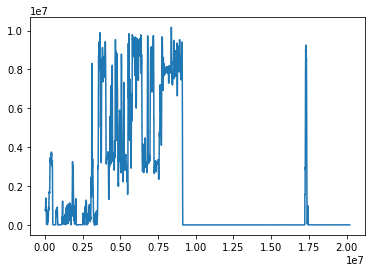

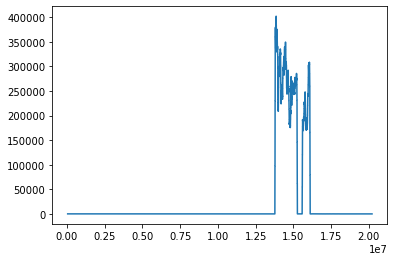

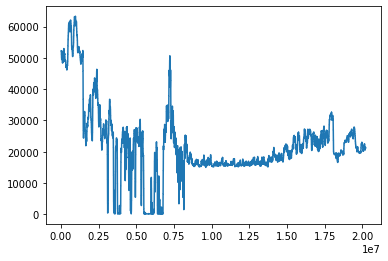

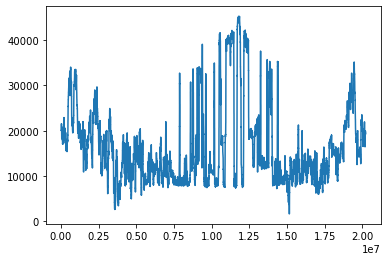

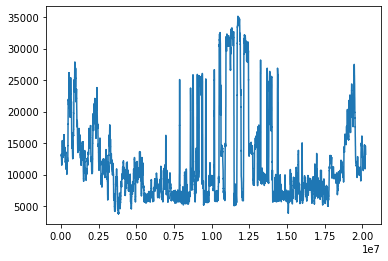

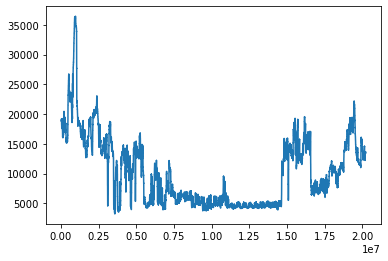

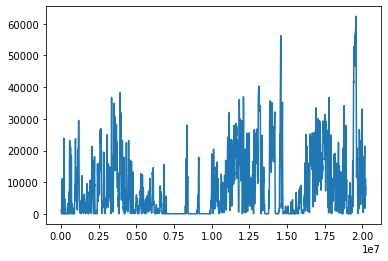

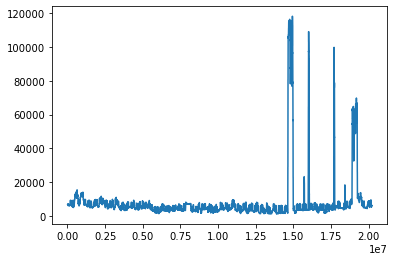

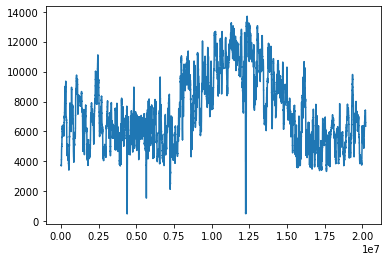

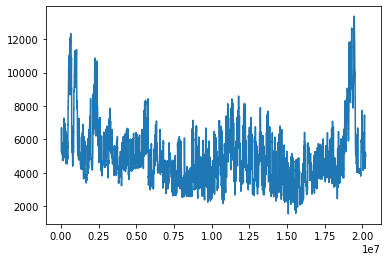

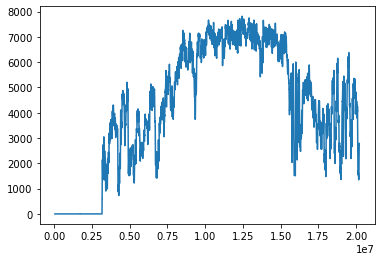

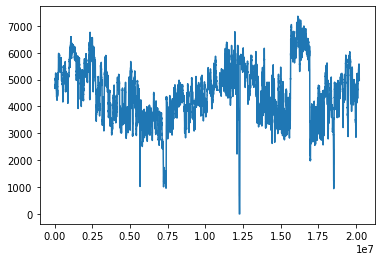

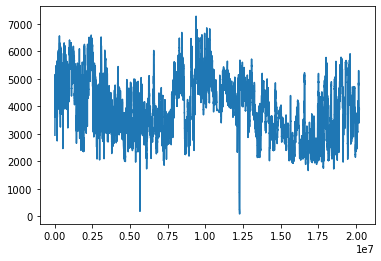

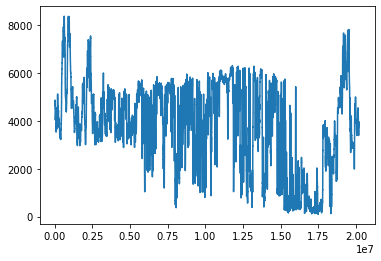

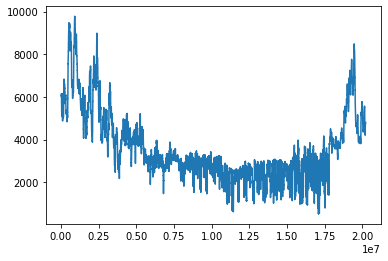

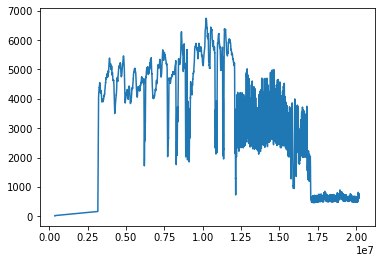

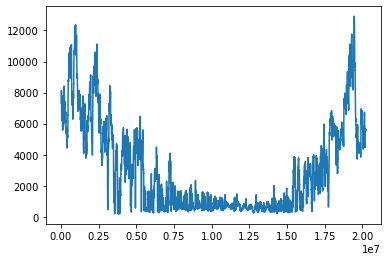

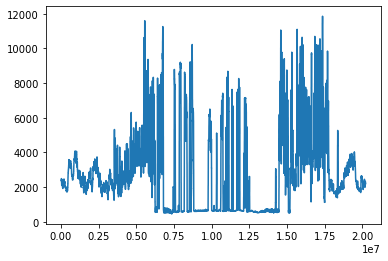

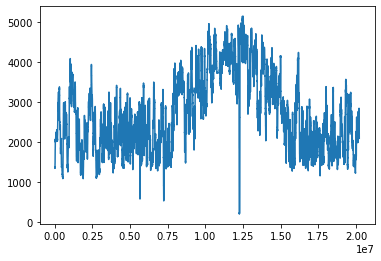

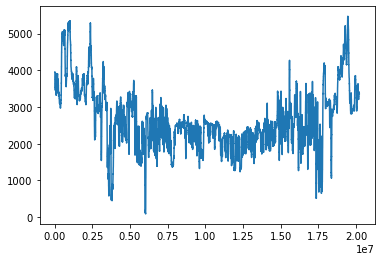

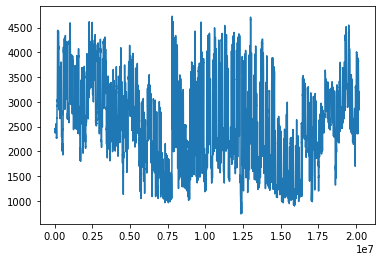

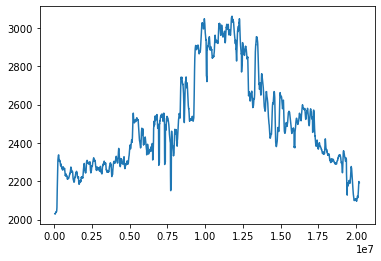

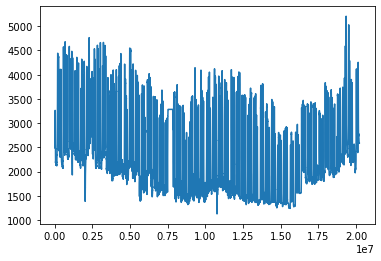

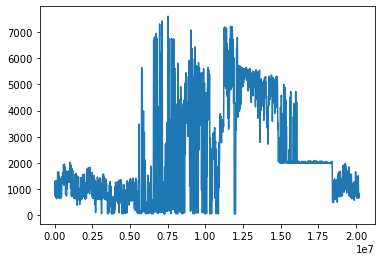

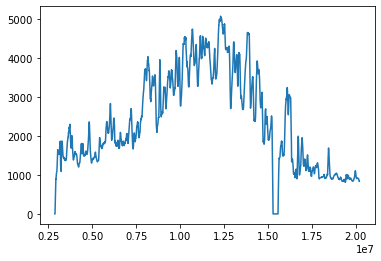

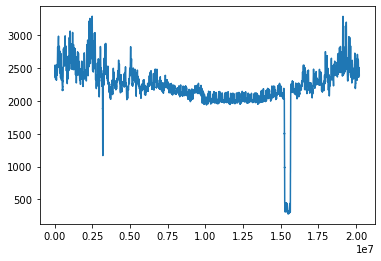

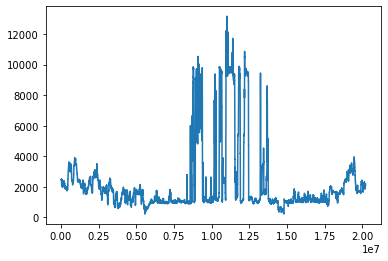

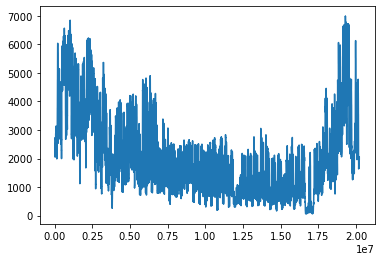

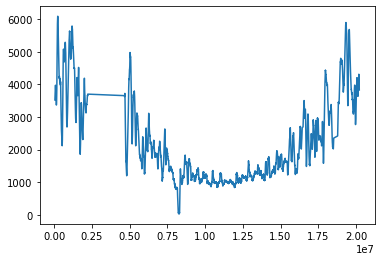

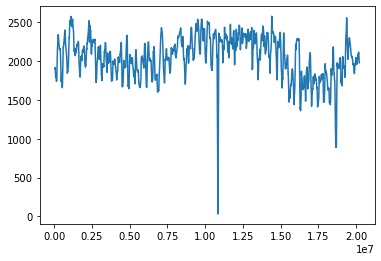

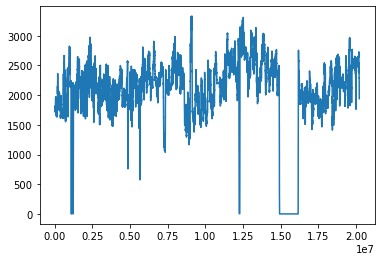

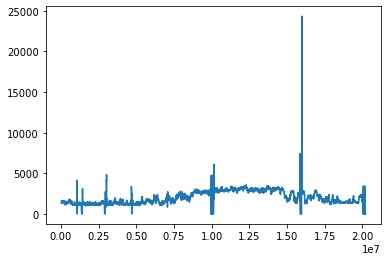

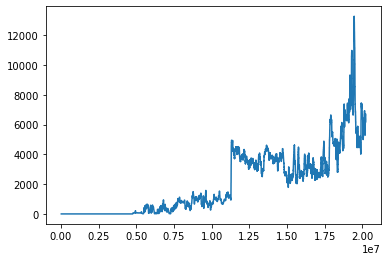

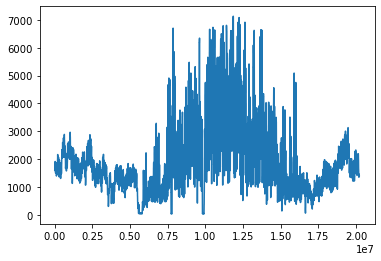

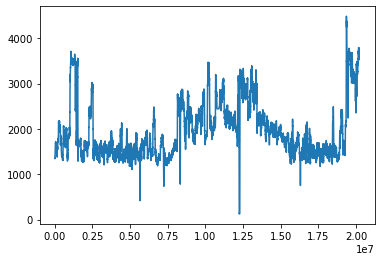

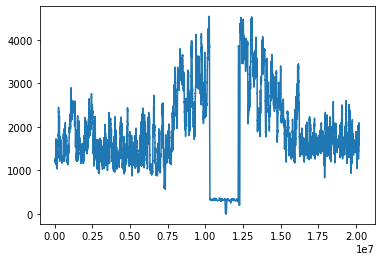

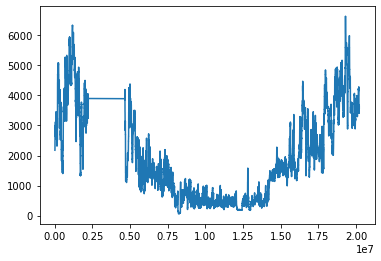

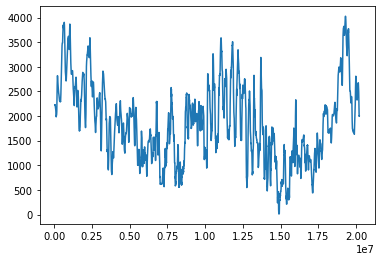

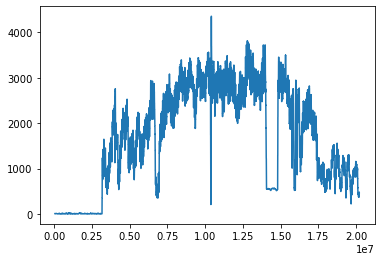

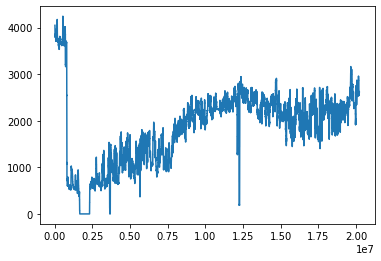

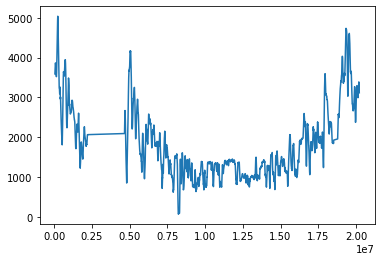

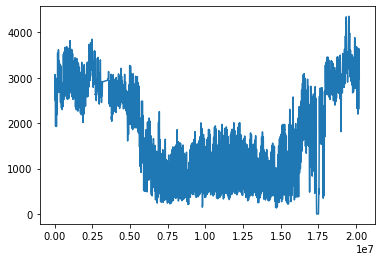

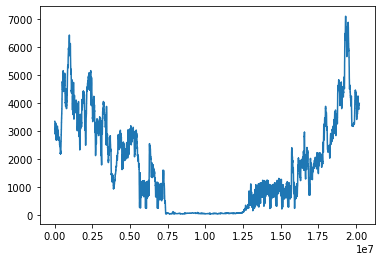

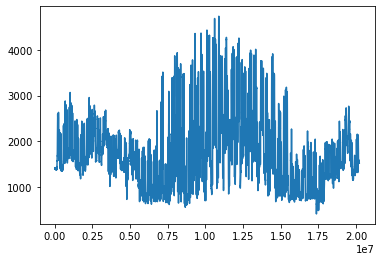

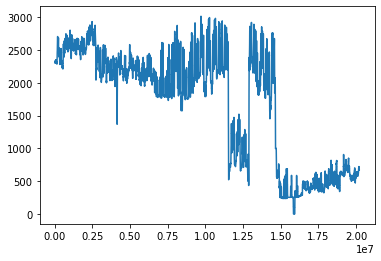

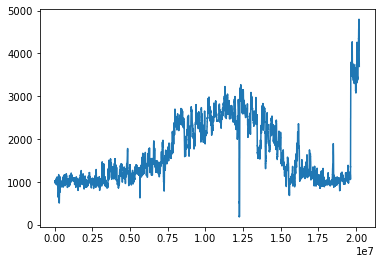

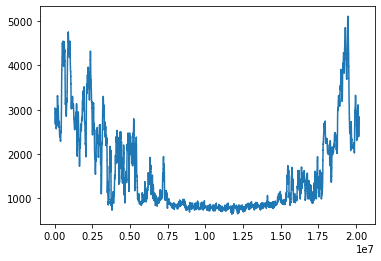

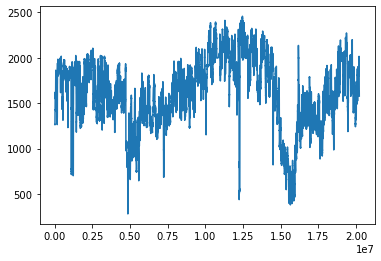

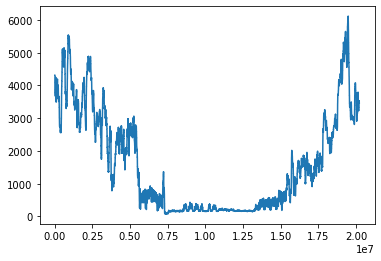

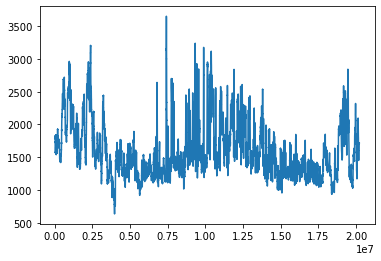

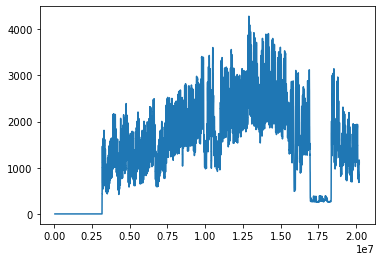

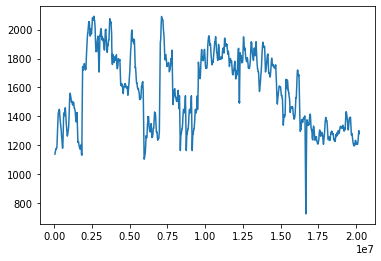

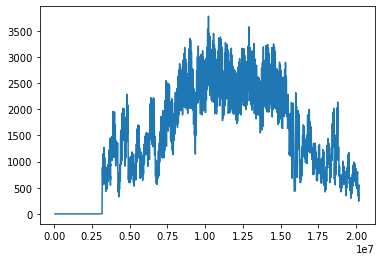

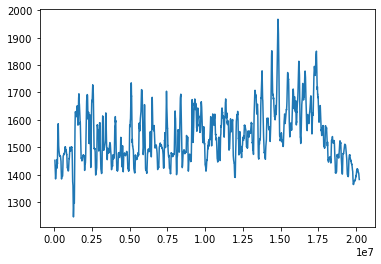

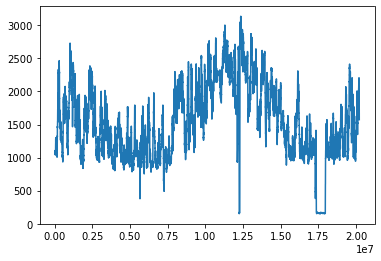

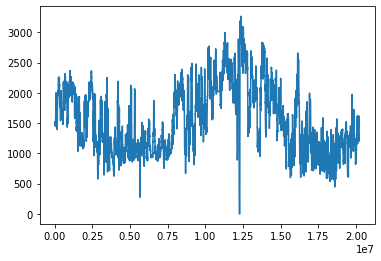

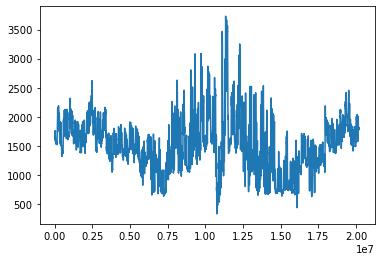

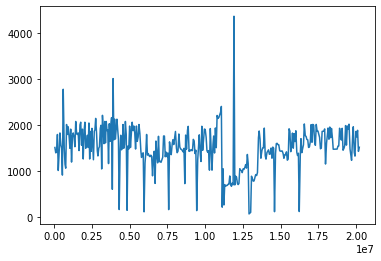

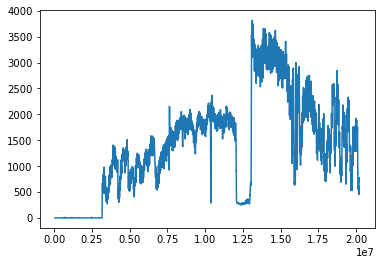

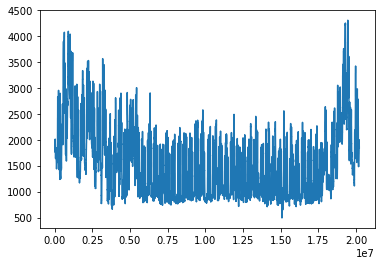

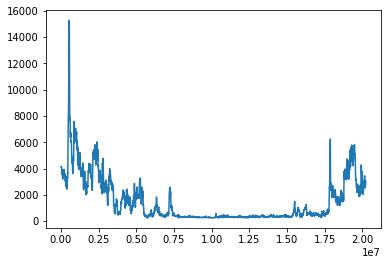

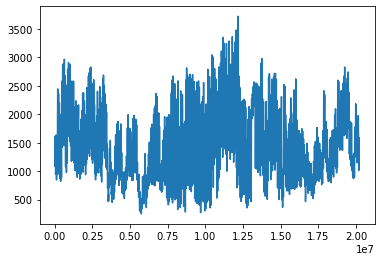

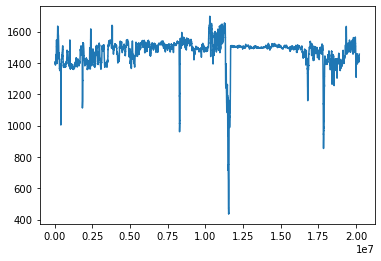

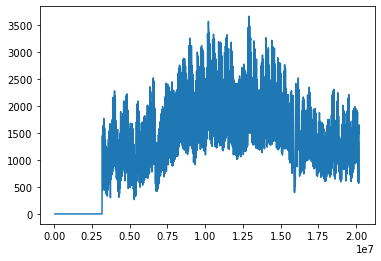

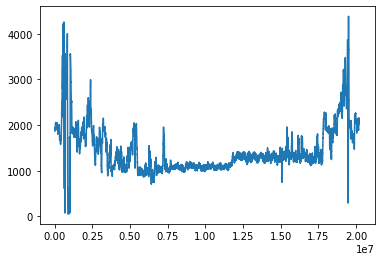

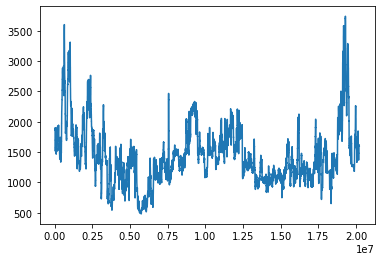

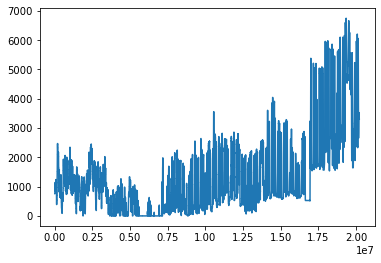

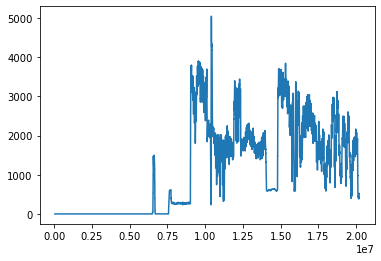

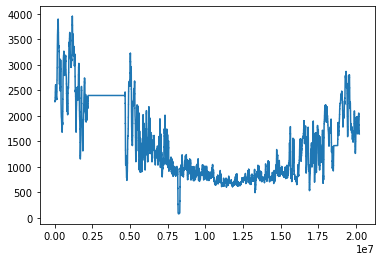

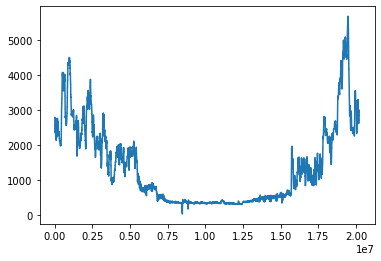

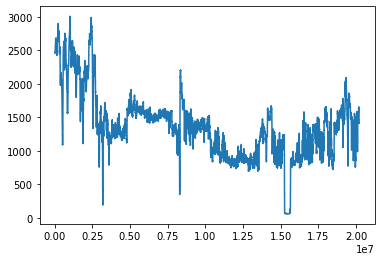

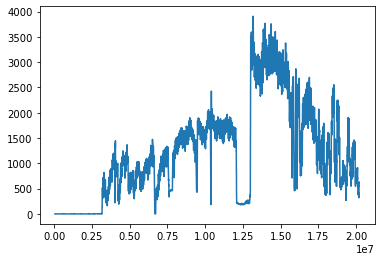

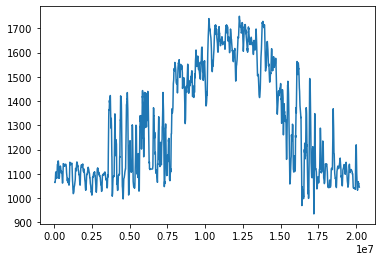

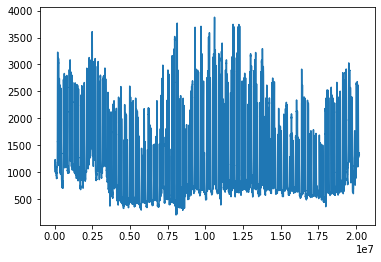

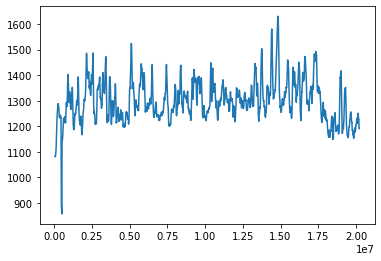

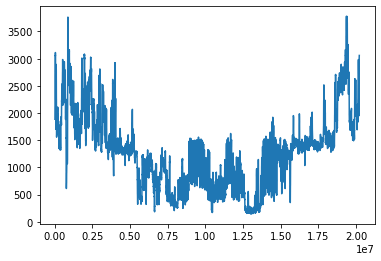

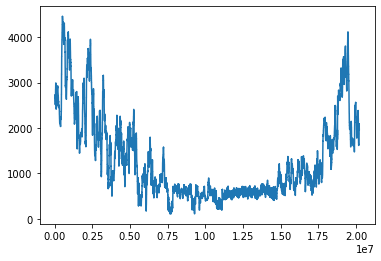

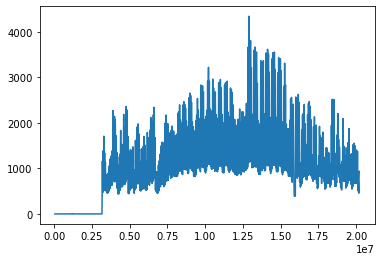

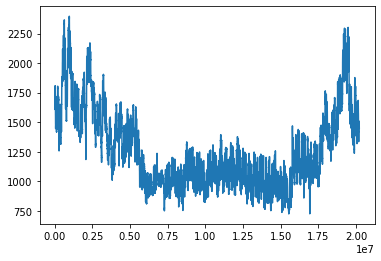

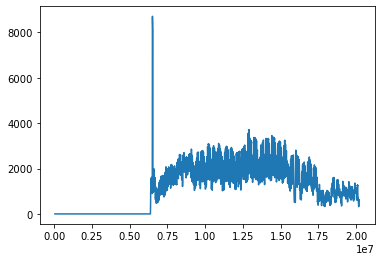

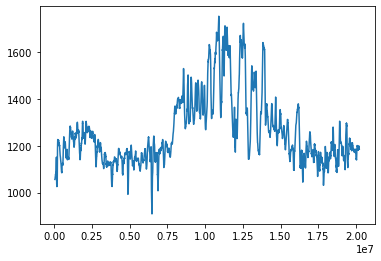

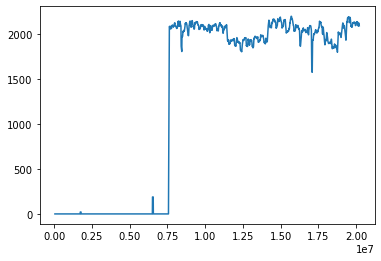

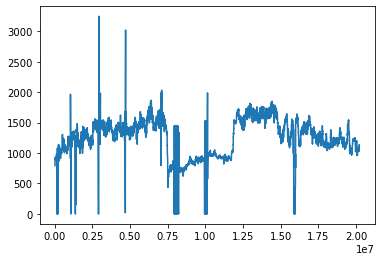

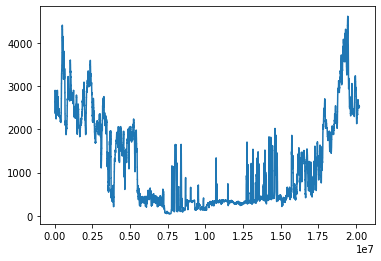

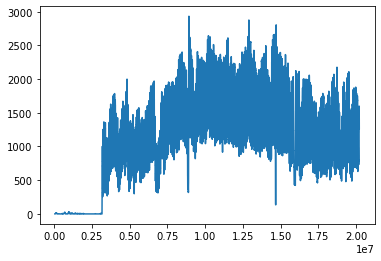

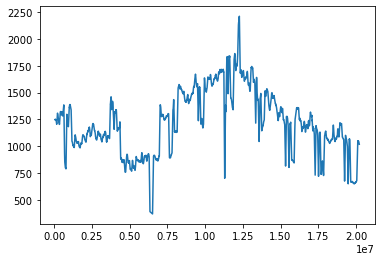

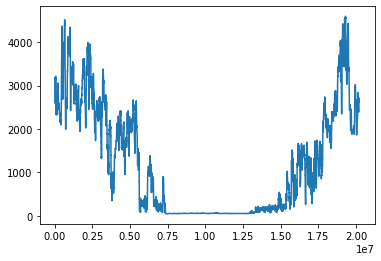

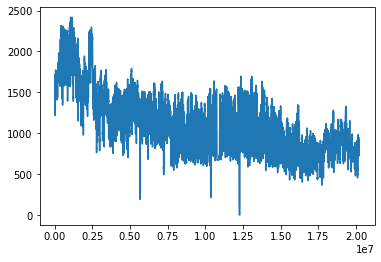

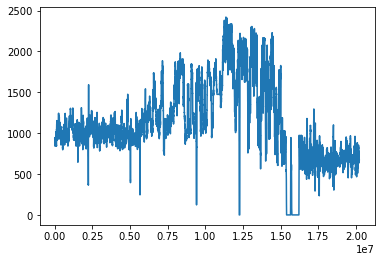

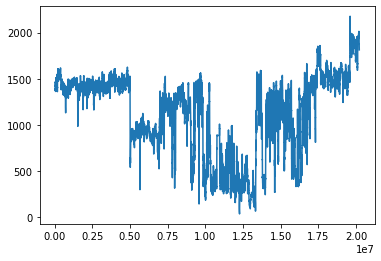

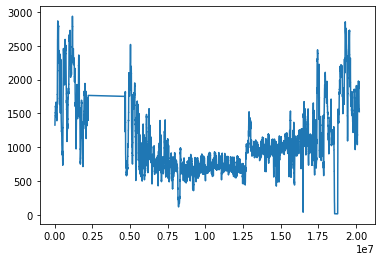

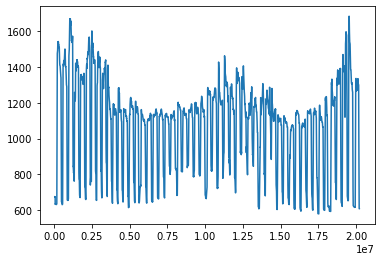

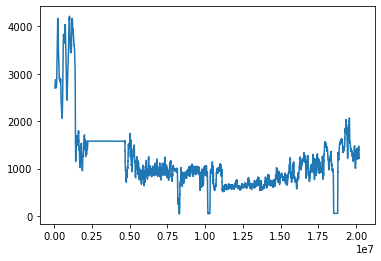

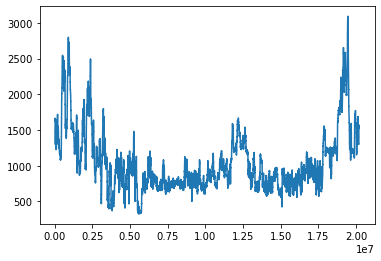

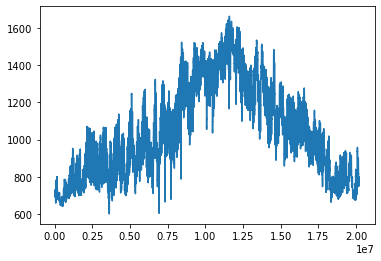

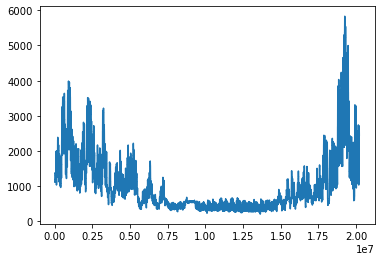

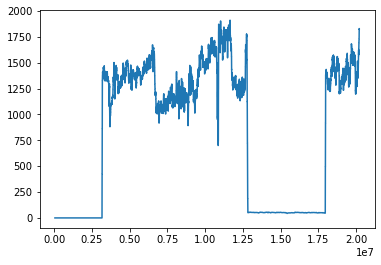

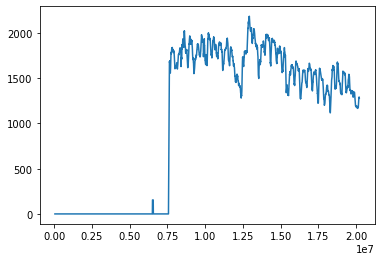

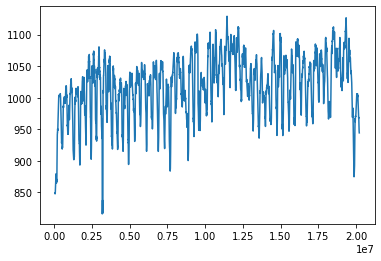

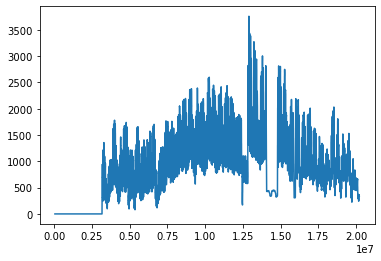

In [21]:
#plotting 100 highest consuming buildings
#import matplotlib.pyplot as plt
topBuildings = train.groupby("building_id")["meter_reading"].mean().sort_values(ascending = False).iloc[:100]

for value in topBuildings.index:
    train[train["building_id"] == value]["meter_reading"].rolling(window = 24).mean().plot()
    plt.show()

array([[<AxesSubplot:title={'center':'building_id'}>,
        <AxesSubplot:title={'center':'meter'}>,
        <AxesSubplot:title={'center':'meter_reading'}>,
        <AxesSubplot:title={'center':'hour'}>],
       [<AxesSubplot:title={'center':'day'}>,
        <AxesSubplot:title={'center':'weekend'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'site_id'}>],
       [<AxesSubplot:title={'center':'primary_use'}>,
        <AxesSubplot:title={'center':'square_feet'}>,
        <AxesSubplot:title={'center':'year_built'}>,
        <AxesSubplot:title={'center':'floor_count'}>],
       [<AxesSubplot:title={'center':'air_temperature'}>,
        <AxesSubplot:title={'center':'cloud_coverage'}>,
        <AxesSubplot:title={'center':'dew_temperature'}>,
        <AxesSubplot:title={'center':'precip_depth_1_hr'}>],
       [<AxesSubplot:title={'center':'sea_level_pressure'}>,
        <AxesSubplot:title={'center':'wind_direction'}>,
        <AxesSubplot:title={'ce

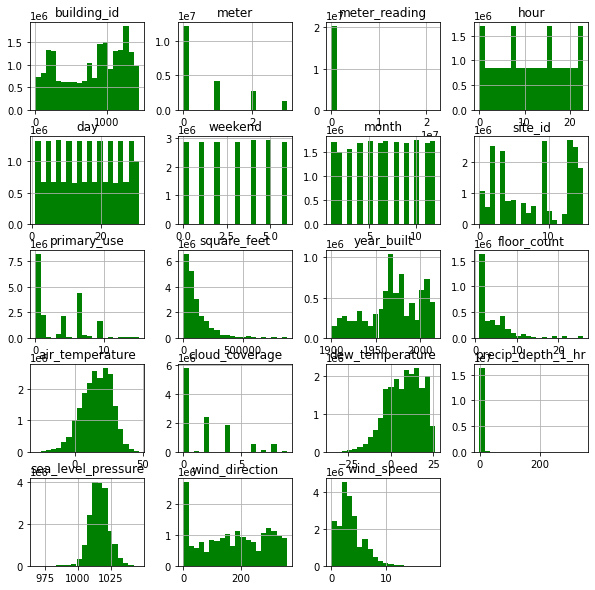

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

train.hist(figsize=(10,10),color="green",bins=20)

In [23]:
target = np.log1p(train["meter_reading"])
del train["meter_reading"]

In [24]:
train = train.drop(dropCols + ["site_id", "floor_count"], axis = 1)
test = test.drop(dropCols + ["site_id", "floor_count","row_id"], axis = 1)

In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   building_id      int16  
 1   meter            int8   
 2   hour             int64  
 3   day              int64  
 4   weekend          int64  
 5   month            int64  
 6   primary_use      int8   
 7   square_feet      int32  
 8   year_built       float16
 9   air_temperature  float16
 10  cloud_coverage   float16
 11  dew_temperature  float16
dtypes: float16(4), int16(1), int32(1), int64(4), int8(2)
memory usage: 1.9 GB


In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   building_id      int16  
 1   meter            int8   
 2   hour             int64  
 3   day              int64  
 4   weekend          int64  
 5   month            int64  
 6   primary_use      int8   
 7   square_feet      int32  
 8   year_built       float16
 9   air_temperature  float16
 10  cloud_coverage   float16
 11  dew_temperature  float16
dtypes: float16(4), int16(1), int32(1), int64(4), int8(2)
memory usage: 925.4 MB


In [28]:
numFolds = 5
kf = KFold(n_splits = numFolds, shuffle = False, random_state = 42)
error = 0
for i, (train_index, val_index) in enumerate(kf.split(train)):
    if i + 1 < numFolds:
        continue
    print(train_index.max(), val_index.min())
    
    #splitting the DF into train-test split
    trainX = train[featCols].iloc[train_index]
    valX = train[featCols].iloc[val_index]
    trainY = target.iloc[train_index]
    valY = target.iloc[val_index]
    
    #training the model
    trainLGB = lgb.Dataset(trainX, trainY > 0)
    evalLGB = lgb.Dataset(valX, valY > 0)
    params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': {'binary_logloss'},
                'learning_rate': 0.1,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 5
             }
    gbm_class = lgb.train(params,
                         trainLGB,
                         num_boost_round = 2000,
                         valid_sets = (trainLGB, evalLGB),
                         early_stopping_rounds = 20,
                         verbose_eval = 20)
    
    #This is for positive values are considered and prevent data leaking
    trainLGB = lgb.Dataset(trainX[trainY > 0], trainY[trainY > 0])
    evalLGB = lgb.Dataset(valX[valY > 0], valY[valY > 0])
    params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': {'rmse'},
                'learning_rate': 0.5,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 5
             }
    
    gbm_regress = lgb.train(params,
                         trainLGB,
                         num_boost_round = 2000,
                         valid_sets = (trainLGB, evalLGB),
                         early_stopping_rounds = 20,
                         verbose_eval = 20)
      
    yPred = (gbm_class.predict(valX, num_iteration=gbm_class.best_iteration) > .5) *\
    (gbm_regress.predict(valX, num_iteration=gbm_regress.best_iteration))
    error += np.sqrt(mean_squared_error(ypred, (valY)))/numFolds
    print(np.sqrt(mean_squared_error(yPred, (valY))))
    break
print (error)

16172879 16172880
[LightGBM] [Info] Number of positive: 14588424, number of negative: 1584456
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.506401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1161
[LightGBM] [Info] Number of data points in the train set: 16172880, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.902030 -> initscore=2.219987
[LightGBM] [Info] Start training from score 2.219987
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.180013	valid_1's binary_logloss: 0.179619
[40]	training's binary_logloss: 0.156394	valid_1's binary_logloss: 0.17163
[60]	training's binary_logloss: 0.1448	valid_1's binary_logloss: 0.171614
[80]	training's binary_logloss: 0.136717	valid_1's binary_logloss: 0.173615
Early stopping, best iteration is:
[63]	training's binary_logloss: 0.143641	valid_1's binary_logloss: 0.171215
[Light

NameError: name 'ypred' is not defined